In [1]:
import pandas as pd
#from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

### Helper Functions

In [2]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    print('Days: ',len(set(data.Date)))
    return data

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['DOLocationID'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
def zscoreNormalizeSpatial(matrix):
    m = matrix.copy()
    for i in range(m.shape[0]):
        m[i, :] = (m[i, :] - m[i, :].mean()) / (m[i, :].std()+1e-10)
        
    return m

In [5]:
def standardize(matrix):
    m = matrix.copy()
    scaler = StandardScaler()
    scaler.fit(m)
    t = scaler.transform(m)
    return scaler, t

In [6]:
def inverse_standardize(matrix, scaler):
    t = matrix.copy()
    return scaler.inverse_transform(t)

In [7]:
def getPCAFeatures(matrix, index, n=10):
    pca = PCA(n_components=n)
    pca.fit(matrix)
    reducedMatrixPCA = pca.transform(matrix)
    reducedMatrixPCA.shape

    reducedDict = {str(i+1):reducedMatrixPCA[:,i] for i in range(reducedMatrixPCA.shape[1])}
    reducedDf = pd.DataFrame(reducedDict)
    reducedDf.index = index
    return pca,reducedDf

In [8]:
def inverse_pca(matrix,pca):
    return pca.inverse_transform(matrix)

In [9]:
def addLag(dataset, maxlag, lagvar):
    # return the full dataset with lag
    LAG = np.arange(1,maxlag + 1)
    lagdata = pd.DataFrame([])
    for lag in LAG:
        varname = str(lagvar)+'_lag' + str(lag)
        lagdata[varname] = dataset[lagvar].loc[maxlag-lag:len(dataset)-lag-1].reset_index(drop = True)
    dataset = pd.concat([dataset.loc[maxlag:].reset_index(drop = True), lagdata.reset_index(drop = True)], axis = 1, sort = False)
    return dataset

In [10]:
def get_rmse(matrix1, matrix2):
    sumSquareError = np.mean(np.power(matrix1 - matrix2,2))
    rmse = np.power(sumSquareError,0.5)
    return rmse

In [21]:
def pca_performance(matrix, components):
    rmseList = []
    r2List = []
    for n in components:
        s,k = standardize(matrix)
        p,k = getPCAFeatures(k, _index, n=n)
        k = inverse_pca(k,p)
        k = inverse_standardize(k, s)
        
        rmseList.append(get_rmse(matrix, k))
        r2List.append(r2_score(matrix, k, multioutput='variance_weighted'))
        
    plt.figure(figsize=(10,5))
    plt.title('RMSE')
    plt.xlabel('components')
    plt.ylabel('rmse')
    plt.plot(component,rmseList)
    plt.figure(figsize=(10,5))
    plt.title('R Squared')
    plt.xlabel('components')
    plt.ylabel('R2')
    plt.plot(component,r2List)
    
    return rmseList,r2List

#### Preparing Data

In [22]:
file = '/home/urwa/Documents/Projects/NYU Remote/project/data/JfkVehiceByHour.csv'

In [23]:
data = loadData(file)

Raw shape:  (4520160, 4)
Days:  730


In [24]:
data = getTimeSeries(data)

In [25]:
_index = data.index

In [26]:
matrix = data.values.astype(np.float64)

In [27]:
data.head(2)

DOLocationID     1    2    3    4    5    6    7    8    9    10  ...   254  \
Date       Hour                                                   ...         
2017-01-01 0       0    0    0    1    0    0    2    0    0    6 ...     0   
           1       0    0    0    1    0    0    3    0    0    5 ...     0   

DOLocationID     255  256  257  258  259  260  261  262  263  
Date       Hour                                               
2017-01-01 0       3    0    2    0    0    1    0    2    0  
           1       3    1    0    0    0    0    1    2    3  

[2 rows x 258 columns]

### PCA performance Check

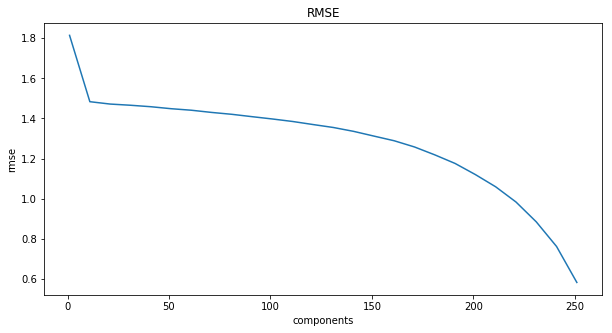

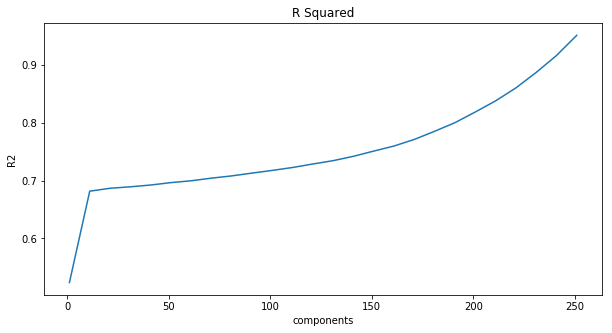

In [28]:
component = list(range(1,data.shape[1],10))
_=pca_performance(matrix, component)